                             LIQUID STAKING DERIVATIVE INDEX OPTIMIZATION

This project aims to optimize the weights of The Liquid Staked ETH index (LSETH) using Genetic Algorithms. The index token contains an equal-weighted basket (20%) of the 5 leading liquid staked Ether derivatives to reduce volatility and mitigate underlying protocol risk compared to holding individual tokens.

Downloading historical prices

In [1]:
import requests
import pandas as pd
from datetime import datetime

index = [
   "rocket-pool-eth",
    "wrapped-steth",
    "staked-frax-ether",
    "coinbase-wrapped-staked-eth",
    "ankreth",
    "liquid-staked-eth-index"
]

data_list = []

for name in index:
    url = f"https://api.coingecko.com/api/v3/coins/{name}/market_chart"
    parameters = {
        "vs_currency": "eth",
         "days": "150"
    }
    response = requests.get(url, params=parameters)

    if response.status_code == 200:
        data = response.json()
        prices = data["prices"]
        for price in prices:
            timestamp = price[0] / 1000  # Convert milliseconds to seconds
            price_value = price[1]
            date = pd.to_datetime(timestamp, unit='s').strftime("%Y-%m-%d")
            data_list.append([name, date, price_value])
    else:
        print(f"Error occurred while retrieving data for {name}.")

# Create a DataFrame from the collected data
df1 = pd.DataFrame(data_list, columns=["Name", "Date", "Price"])
df1 = df1.sort_values("Date")
df1.set_index("Date", inplace=True)

df1

,Name,Price
Date,,
2023-01-15,rocket-pool-eth,1.066722
2023-01-15,ankreth,1.026785
2023-01-15,coinbase-wrapped-staked-eth,0.987951
2023-01-15,staked-frax-ether,1.015723
2023-01-15,wrapped-steth,1.097225
...,...,...
2023-06-13,coinbase-wrapped-staked-eth,1.038241
2023-06-13,rocket-pool-eth,1.074298
2023-06-13,rocket-pool-eth,1.074591


In [2]:
pivot_df1 = df1.pivot_table(index=df1.index, columns='Name', values='Price')
pivot_df1

Name,ankreth,coinbase-wrapped-staked-eth,liquid-staked-eth-index,rocket-pool-eth,staked-frax-ether,wrapped-steth
Date,,,,,,
2023-01-15,1.026785,0.987951,NaN,1.066722,1.015723,1.097225
2023-01-16,1.004351,0.987675,NaN,1.064756,1.015964,1.096141
2023-01-17,0.973837,0.990344,NaN,1.069676,1.013531,1.099075
2023-01-18,1.030344,0.994129,NaN,1.064854,1.012423,1.098706
2023-01-19,1.028569,0.997020,NaN,1.066325,1.010846,1.099061
...,...,...,...,...,...,...
2023-06-09,1.117357,1.037402,NaN,1.074398,1.043445,1.127916
2023-06-10,1.112879,1.037661,NaN,1.074277,1.042319,1.126968
2023-06-11,1.113508,1.036198,NaN,1.073126,1.042534,1.126674


Imputing missing values

In [3]:
from sklearn.impute import KNNImputer

# Define the KNN imputer
imputer = KNNImputer(n_neighbors=5)

# Perform KNN imputation
imputed_data = imputer.fit_transform(pivot_df1)

# Convert the imputed data back to a DataFrame
pivot_df1 = pd.DataFrame(imputed_data, index=pivot_df1.index, columns=pivot_df1.columns)
pivot_df1

Name,ankreth,coinbase-wrapped-staked-eth,liquid-staked-eth-index,rocket-pool-eth,staked-frax-ether,wrapped-steth
Date,,,,,,
2023-01-15,1.026785,0.987951,1.011608,1.066722,1.015723,1.097225
2023-01-16,1.004351,0.987675,1.013843,1.064756,1.015964,1.096141
2023-01-17,0.973837,0.990344,1.015541,1.069676,1.013531,1.099075
2023-01-18,1.030344,0.994129,1.011608,1.064854,1.012423,1.098706
2023-01-19,1.028569,0.997020,1.011608,1.066325,1.010846,1.099061
...,...,...,...,...,...,...
2023-06-09,1.117357,1.037402,0.993350,1.074398,1.043445,1.127916
2023-06-10,1.112879,1.037661,0.995616,1.074277,1.042319,1.126968
2023-06-11,1.113508,1.036198,0.995802,1.073126,1.042534,1.126674


Plotting Returns and Volatilities

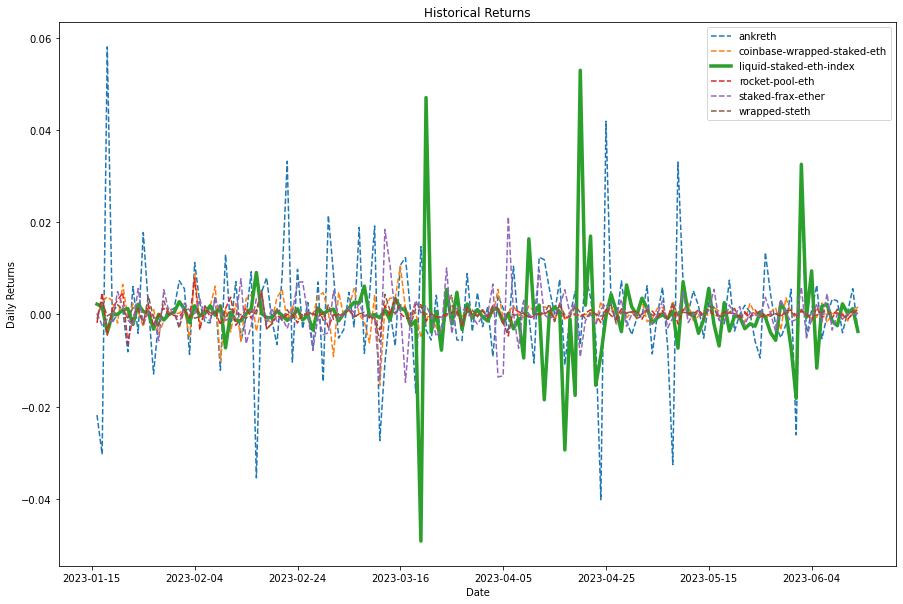

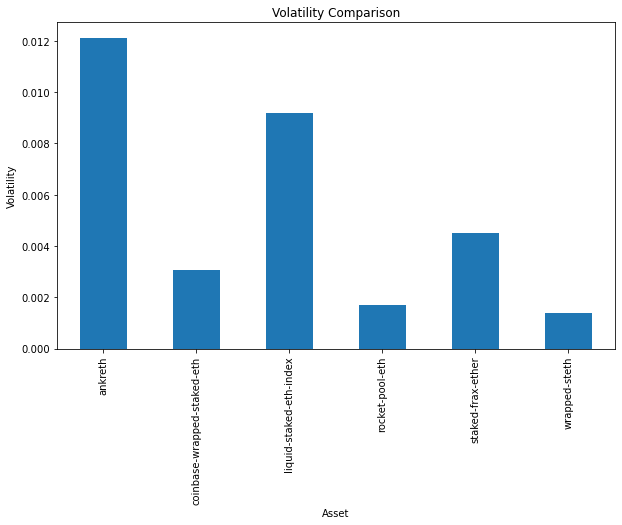

In [4]:
import matplotlib.pyplot as plt

# Calculate daily returns
returns = pivot_df1.pct_change()

# Calculate volatility (standard deviation of returns)
volatility = returns.std()

# Plotting the returns
plt.figure(figsize=(15, 10))
for col in returns.columns:
    if col == 'liquid-staked-eth-index':
        returns[col].plot(ax=plt.gca(), label=col, linewidth=3.5)
    else:
        returns[col].plot(ax=plt.gca(), linestyle='--', label=col)
plt.ylabel('Daily Returns')
plt.title('Historical Returns')
plt.legend()
plt.show()

# Plotting the volatility
plt.figure(figsize=(10, 6))
volatility.plot(kind='bar')
plt.xlabel('Asset')
plt.ylabel('Volatility')
plt.title('Volatility Comparison')
plt.show()

We can actually see that LSETH index shows a bigger volatilty compared to most liquid staked derivatives...

Downloading individual token historical prices

In [5]:
tokens = [
    "rocket-pool-eth",
    "wrapped-steth",
    "staked-frax-ether",
    "coinbase-wrapped-staked-eth",
    "ankreth"
]

data_list = []

for name in tokens:
    url = f"https://api.coingecko.com/api/v3/coins/{name}/market_chart"
    parameters = {
        "vs_currency": "eth",
         "days": "150"
    }
    response = requests.get(url, params=parameters)

    if response.status_code == 200:
        data = response.json()
        prices = data["prices"]
        for price in prices:
            timestamp = price[0] / 1000  # Convert milliseconds to seconds
            price_value = price[1]
            date = pd.to_datetime(timestamp, unit='s').strftime("%Y-%m-%d")
            data_list.append([name, date, price_value])
    else:
        print(f"Error occurred while retrieving data for {name}.")

# Create a DataFrame from the collected data
df2 = pd.DataFrame(data_list, columns=["Name", "Date", "Price"])
df2 = df2.sort_values("Date")
df2.set_index("Date", inplace=True)

df2

,Name,Price
Date,,
2023-01-15,rocket-pool-eth,1.066722
2023-01-15,ankreth,1.026785
2023-01-15,wrapped-steth,1.097225
2023-01-15,coinbase-wrapped-staked-eth,0.987951
2023-01-15,staked-frax-ether,1.015723
...,...,...
2023-06-13,staked-frax-ether,1.043318
2023-06-13,staked-frax-ether,1.042482
2023-06-13,ankreth,1.116296


In [6]:
pivot_df2 = df2.pivot_table(index=df2.index, columns='Name', values='Price')
pivot_df2

Name,ankreth,coinbase-wrapped-staked-eth,rocket-pool-eth,staked-frax-ether,wrapped-steth
Date,,,,,
2023-01-15,1.026785,0.987951,1.066722,1.015723,1.097225
2023-01-16,1.004351,0.987675,1.064756,1.015964,1.096141
2023-01-17,0.973837,0.990344,1.069676,1.013531,1.099075
2023-01-18,1.030344,0.994129,1.064854,1.012423,1.098706
2023-01-19,1.028569,0.997020,1.066325,1.010846,1.099061
...,...,...,...,...,...
2023-06-09,1.117357,1.037402,1.074398,1.043445,1.127916
2023-06-10,1.112879,1.037661,1.074277,1.042319,1.126968
2023-06-11,1.113508,1.036198,1.073126,1.042534,1.126674


In [7]:
# Define the KNN imputer
imputer = KNNImputer(n_neighbors=5)

# Perform KNN imputation
imputed_data = imputer.fit_transform(pivot_df2)

# Convert the imputed data back to a DataFrame
pivot_df2 = pd.DataFrame(imputed_data, index=pivot_df2.index, columns=pivot_df2.columns)
pivot_df2

Name,ankreth,coinbase-wrapped-staked-eth,rocket-pool-eth,staked-frax-ether,wrapped-steth
Date,,,,,
2023-01-15,1.026785,0.987951,1.066722,1.015723,1.097225
2023-01-16,1.004351,0.987675,1.064756,1.015964,1.096141
2023-01-17,0.973837,0.990344,1.069676,1.013531,1.099075
2023-01-18,1.030344,0.994129,1.064854,1.012423,1.098706
2023-01-19,1.028569,0.997020,1.066325,1.010846,1.099061
...,...,...,...,...,...
2023-06-09,1.117357,1.037402,1.074398,1.043445,1.127916
2023-06-10,1.112879,1.037661,1.074277,1.042319,1.126968
2023-06-11,1.113508,1.036198,1.073126,1.042534,1.126674


Downloading historical LSETH prices

In [8]:
token = [
    "liquid-staked-eth-index"
]

data_list = []

for name in token:
    url = f"https://api.coingecko.com/api/v3/coins/{name}/market_chart"
    parameters = {
        "vs_currency": "eth",
        "days": "150"
    }
    response = requests.get(url, params=parameters)

    if response.status_code == 200:
        data = response.json()
        prices = data["prices"]
        for price in prices:
            timestamp = price[0] / 1000  # Convert milliseconds to seconds
            price_value = price[1]
            date = datetime.fromtimestamp(timestamp).strftime("%Y-%m-%d")
            data_list.append([name, date, price_value])
    else:
        print(f"Error occurred while retrieving data for {name}.")

# Create a DataFrame from the collected data
df_index= pd.DataFrame(data_list, columns=["Name", "Date", "Price"])


# Sort DataFrame by "Date"
df_index = df_index.sort_values("Date")
df_index.set_index("Date", inplace=True)
df_index

,Name,Price
Date,,
2023-01-28,liquid-staked-eth-index,1.010372
2023-01-29,liquid-staked-eth-index,1.010372
2023-01-30,liquid-staked-eth-index,1.010793
2023-01-31,liquid-staked-eth-index,1.013571
2023-02-01,liquid-staked-eth-index,1.014740
...,...,...
2023-05-28,liquid-staked-eth-index,0.989419
2023-05-29,liquid-staked-eth-index,0.989939
2023-05-30,liquid-staked-eth-index,1.000700


In [9]:
# Drop the 'Name' column
df_index.drop('Name', axis=1, inplace=True)

# Replace the 'Price' column with 'liquid-staked-eth-index'
df_index.rename(columns={'Price': 'liquid-staked-eth-index'}, inplace=True)
df_index

,liquid-staked-eth-index
Date,
2023-01-28,1.010372
2023-01-29,1.010372
2023-01-30,1.010793
2023-01-31,1.013571
2023-02-01,1.014740
...,...
2023-05-28,0.989419
2023-05-29,0.989939
2023-05-30,1.000700


Running the Optimization 

In [10]:
import random
import numpy as np
from deap import base, creator, tools, algorithms

# Define the currency names
cryptocurrencies = tokens

# Calculate the variances
variance = pivot_df2.var()

# Calculate the covariances
covariance_matrix = pivot_df2.cov()

# Step 1: Define the Problem - Objective Function
def calculate_portfolio_risk(weights, covariance_matrix):
    portfolio_variance = np.dot(weights, np.dot(covariance_matrix, weights))
    return portfolio_variance

def normalize_weights(weights):
    sum_weights = sum(weights)
    normalized_weights = [(w / sum_weights) for w in weights]
    bounded_weights = [max(0, min(w, 1)) for w in normalized_weights]
    return bounded_weights

def evaluate(individual):
    # Calculate portfolio risk (variance) based on weights
    weights = normalize_weights(individual)
    risk = calculate_portfolio_risk(weights, covariance_matrix)
    return -risk,  # Negative sign to minimize the risk

# Define the components and number of currencies
components = tokens
num_currencies = len(components)

population_size = 100
num_generations = 50

# Define the Individual Representation
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

# Define the Genetic Operators
toolbox = base.Toolbox()
toolbox.register("attribute", random.uniform, 0, 1)  # Range set to (0, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attribute, n=num_currencies)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", evaluate)
toolbox.register("mate", tools.cxBlend, alpha=0.5)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=10, indpb=0.1)
toolbox.register("select", tools.selRoulette)

# Define the Evolutionary Algorithm
population = toolbox.population(n=population_size)
hof = tools.HallOfFame(1)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

algorithms.eaSimple(population, toolbox, cxpb=0.5, mutpb=0.2, ngen=num_generations, stats=stats, halloffame=hof)

# Retrieve the best individual and its corresponding weights
best_individual = hof[0]
best_weights = normalize_weights(best_individual)
sum_weights = sum(best_weights)
best_weights = [w / sum_weights for w in best_weights]

print("Best Portfolio Weights:")
for token, weight in zip(components, best_weights):
    print(token + ": " + str(weight))

gen	nevals	avg         	std        	min         	max         
0  	100   	-0.000155784	7.11083e-05	-0.000344448	-2.75433e-05
1  	54    	-0.000328947	5.75802e-05	-0.000344448	-6.27398e-05
2  	46    	-0.000338089	7.84752e-05	-0.000903067	-1.86958e-05
3  	60    	-0.000881495	0.000102479	-0.000960461	-0.000107521
4  	64    	-0.00095094 	8.56338e-05	-0.00114956 	-0.00032883 
5  	64    	-0.00115101 	0.000146361	-0.002343   	-0.000737708
6  	59    	-0.00220983 	0.000483612	-0.002343   	-8.14939e-06
7  	56    	-0.002233   	0.00046843 	-0.002343   	-6.7058e-05 
8  	56    	-0.00215463 	0.000561638	-0.002343   	-8.14939e-06
9  	54    	-0.00224465 	0.000424918	-0.002343   	-8.5973e-05 
10 	37    	-0.00225225 	0.000428155	-0.002343   	-8.14939e-06
11 	51    	-0.00223636 	0.000440317	-0.002343   	-8.14939e-06
12 	46    	-0.00226814 	0.000381006	-0.00263392 	-8.14939e-06
13 	44    	-0.00251646 	0.000492036	-0.00270425 	-8.5973e-05 
14 	38    	-0.00265621 	0.000328045	-0.00279105 	-8.14939e-06
15 	48  

In [11]:
# Create a DataFrame with currency-weight pairs
weights_df = pd.DataFrame({'Weight': best_weights}, index=components)
weights_df.index.name = 'Token'
weights_df

,Weight
Token,
rocket-pool-eth,0.25
wrapped-steth,0.25
staked-frax-ether,0.00
coinbase-wrapped-staked-eth,0.25
ankreth,0.25


In [12]:
# Multiply each column of pivot_df by the corresponding weight
weighted_pivot_df = pivot_df2.multiply(weights_df['Weight'], axis=1)

In [13]:
# Calculate the historical cumulative sum of the weights
weighted_pivot_df['Optimized Basket'] = weighted_pivot_df.sum(axis=1)
weighted_pivot_df

,ankreth,coinbase-wrapped-staked-eth,rocket-pool-eth,staked-frax-ether,wrapped-steth,Optimized Basket
Date,,,,,,
2023-01-15,0.256696,0.246988,0.266680,0.0,0.274306,1.044671
2023-01-16,0.251088,0.246919,0.266189,0.0,0.274035,1.038231
2023-01-17,0.243459,0.247586,0.267419,0.0,0.274769,1.033233
2023-01-18,0.257586,0.248532,0.266213,0.0,0.274677,1.047008
2023-01-19,0.257142,0.249255,0.266581,0.0,0.274765,1.047744
...,...,...,...,...,...,...
2023-06-09,0.279339,0.259351,0.268599,0.0,0.281979,1.089268
2023-06-10,0.278220,0.259415,0.268569,0.0,0.281742,1.087946
2023-06-11,0.278377,0.259049,0.268281,0.0,0.281668,1.087376


In [14]:
weighted_pivot_df = weighted_pivot_df.loc['2023-01-28':]

Merging Optimized Basket with LSETH

In [15]:
# Merge the two DataFrames based on the index
merged_df = weighted_pivot_df.merge(df_index, left_index=True, right_index=True)

In [16]:
merged_df=merged_df[['Optimized Basket','liquid-staked-eth-index']]
merged_df

,Optimized Basket,liquid-staked-eth-index
Date,,
2023-01-28,1.049310,1.010372
2023-01-29,1.049903,1.010372
2023-01-30,1.050497,1.010793
2023-01-31,1.050927,1.013571
2023-02-01,1.051897,1.014740
...,...,...
2023-05-28,1.087396,0.989419
2023-05-29,1.084897,0.989939
2023-05-30,1.085471,1.000700


Plotting the graphs

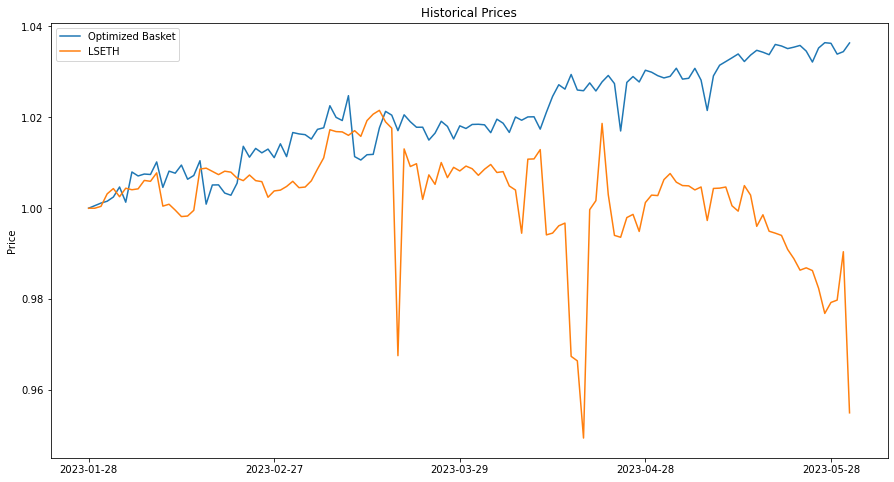

In [17]:
import matplotlib.ticker as ticker

fig, ax = plt.subplots(figsize=(15, 8))

# Set price data to start at 1
normalized_optimized_basket = merged_df['Optimized Basket'] / merged_df['Optimized Basket'].iloc[0]
normalized_lseth = merged_df['liquid-staked-eth-index'] / merged_df['liquid-staked-eth-index'].iloc[0]

# Plot price data
ax.plot(merged_df.index, normalized_optimized_basket, label='Optimized Basket')
ax.plot(merged_df.index, normalized_lseth, label='LSETH')
ax.set_ylabel('Price')
ax.set_title('Historical Prices')
ax.legend()

# Set tick frequency to show dates every 30 days
ax.xaxis.set_major_locator(ticker.MultipleLocator(30))

plt.show()


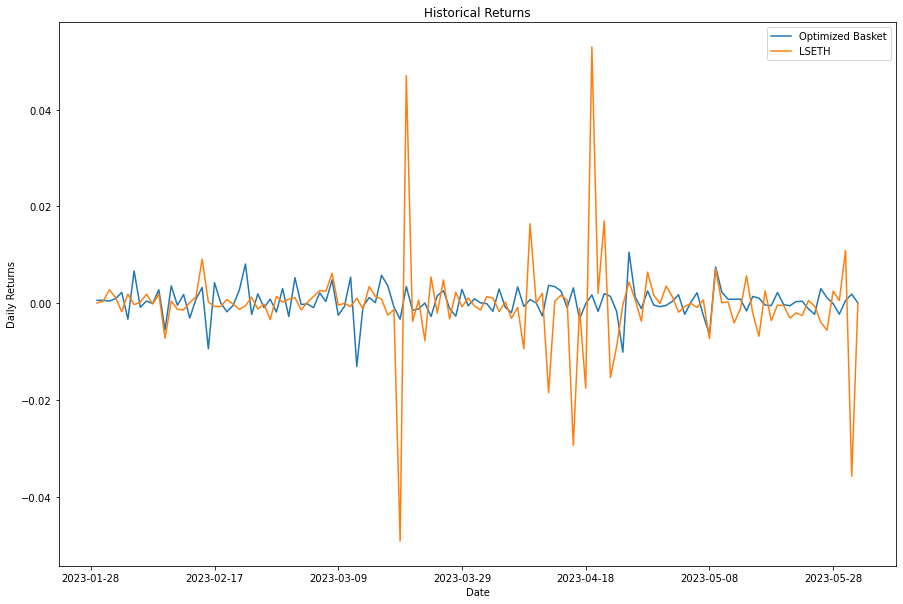

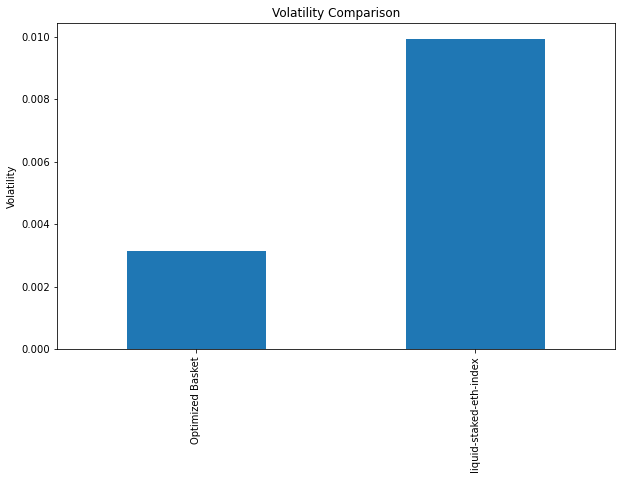

In [18]:
# Calculate daily returns
returns = merged_df[['Optimized Basket','liquid-staked-eth-index',]].pct_change()

# Calculate volatility (standard deviation of returns)
volatility = returns.std()

# Plotting the returns
plt.figure(figsize=(15, 10))
returns.plot(ax=plt.gca())
plt.ylabel('Daily Returns')
plt.title('Historical Returns')
plt.legend(['Optimized Basket', 'LSETH'])
plt.show()

# Plotting the volatility
plt.figure(figsize=(10, 6))
volatility.plot(kind='bar')
plt.ylabel('Volatility')
plt.title('Volatility Comparison')
plt.show()



We can see that the Optimized Basket generated better results and lower volatilty. The optimized basket can still provide some diversification and mitigate underlying protocol risk compared to holding individual tokens.